# AMAL : TP4

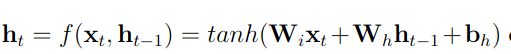

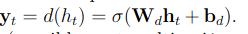

In [35]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class RNN(nn.Module):
    
    def __init__(self,nb_dim,nb_latent,nb_output,nb_timestep,device) :
        super().__init__()
        
        self.nb_dim = nb_dim
        self.nb_latent = nb_latent
        self.nb_output = nb_output
        self.nb_timestep = nb_timestep
        
        self.weights_i = nn.Linear(nb_dim, nb_latent)
        
        self.weights_h = nn.Linear(nb_latent, nb_latent)
        
        self.weights_d = nn.Sequential(
            nn.Linear(nb_latent, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, nb_output)
        )
        
        
    def onestep(self,x,h) :
        """
        input :
        x : batch * dim
        h : batch * latent
        
        return :
            batch * latent
        """
        return torch.tanh((self.weights_i(x) +  self.weights_h(h) ))
    
    def forward(self,x,h) :
        """
        input : 
        x : length * batch * dim
        h : batch * latent 
        return :
            length * batch * latent
        """
        result = list()
        
        for t in range(x.shape[0]) :
            
            h = self.onestep(x[t],h)
            
            result.append(h.unsqueeze(0))
            
        result_t = torch.cat(result,dim=0)
        
        return result_t
        
    def decode(self,h) :
        """
        input : 
        h : batch * latent
        
        return :
            batch * output
        """
        return torch.softmax(torch.sigmoid(self.weights_d(h)),dim=1)

In [28]:
class SampleMetroDataset(Dataset):
    
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data, length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.classes*self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## transformation de l'index 1d vers une indexation 3d
        ## renvoie une séquence de longueur length et l'id de la station.
        station = i // ((self.nb_timeslots-self.length) * self.nb_days)
        i = i % ((self.nb_timeslots-self.length) * self.nb_days)
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length),station],station

class ForecastMetroDataset(Dataset):
    
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data,length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## Transformation de l'indexation 1d vers indexation 2d
        ## renvoie x[d,t:t+length-1,:,:], x[d,t+1:t+length,:,:]
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length-1)],self.data[day,(timeslot+1):(timeslot+self.length)]

In [33]:
def get_Xy(ds) :
    X = list()
    y = list()

    for i in range(len(ds)):
        x_,y_ = ds.__getitem__(i)
        X.append( x_.detach().numpy() )
        y.append( y_ )

    y = np.asarray(y)
    X = np.asarray(X , dtype = np.float32)
    return X,y

def score_many_to_one(Xy, data, rnn) :
    X,y = Xy
    Xt = torch.as_tensor(X, dtype = torch.float32).transpose(0,1)

    h = torch.zeros((Xt.shape[1],nb_latent)).to(device)
    y_pred = rnn.forward(Xt,h)[-1,:,:] # on garde le dernier
    y_decode = torch.argmax(rnn.decode(y_pred),dim=1).detach().numpy()
    return (y_decode == y).sum() / len(y) * 100

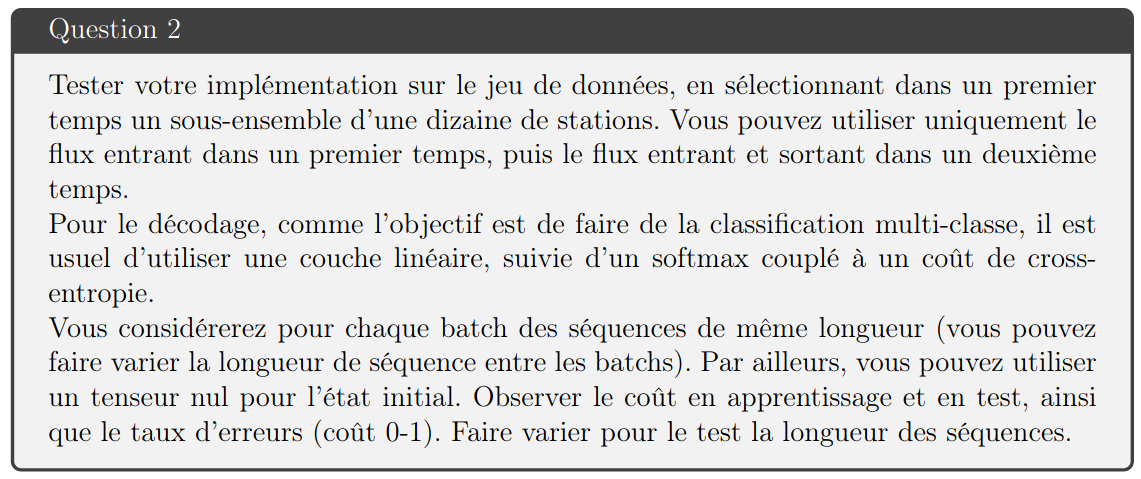

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device =  torch.device("cpu") #  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

def onehot(y):
    onehot = np.zeros((y.shape[0],CLASSES))
    onehot[np.arange(y.shape[0]), y] = 1
    return onehot

PATH = "data/"
matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch","rb"))
ds_train = SampleMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test=SampleMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length = LENGTH, stations_max = ds_train.stations_max)
data_train = DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=False)

device : cpu


In [6]:
nb_dim = DIM_INPUT
nb_output = CLASSES
nb_timestep = LENGTH
batch = BATCH_SIZE
nb_latent = 10
nb_epoch = 500

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0004)

writer = SummaryWriter("./runs/tp4_question2")

print(f"batch : {batch}")
print(f"nb_dim : {nb_dim}")
print(f"length : {nb_timestep}")
print(f"nb_latent : {nb_latent}")

list_error = list()
list_score_train = list()
list_score_test = list()


Xytrain = get_Xy(ds_train)
Xytest = get_Xy(ds_test)


for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in data_train :
        
        y = onehot(y)
        y_t = torch.as_tensor(y , dtype = torch.float32, device = device)
        X_t = torch.as_tensor(X , dtype = torch.float32, device = device).transpose(0,1)      

        if X_t.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X_t,h)

        r = y_pred[-1,:,:]

        y_decode = rnn.decode(r)

        ce = torch.nn.CrossEntropyLoss()

        loss = ce(y_decode,y_t)
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    list_score_train.append(score_many_to_one(Xytrain, data_train, rnn))
    list_score_test.append(score_many_to_one(Xytest, data_test, rnn))
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

2022-10-16 18:30:14.708069: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jdufou1/catkin_ws/devel/lib:/home/jdufou1/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-10-16 18:30:14.708306: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


batch : 32
nb_dim : 2
length : 20
nb_latent : 10


100%|█████████████████████████████████████████| 500/500 [11:18<00:00,  1.36s/it]


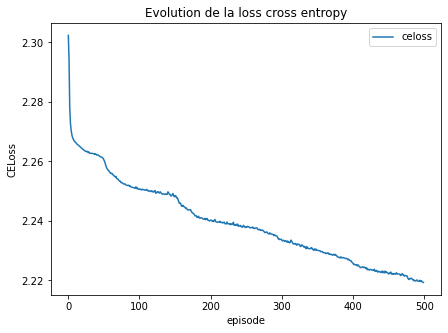

In [7]:
plt.figure(figsize=(7,5))
plt.title("Evolution de la loss cross entropy")
plt.xlabel("episode")
plt.ylabel("CELoss")
plt.plot(list_error, label = "celoss")
plt.legend()
plt.show()

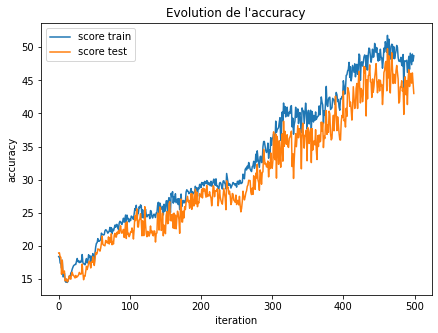

In [8]:
plt.figure(figsize=(7,5))
plt.title("Evolution de l'accuracy")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.plot(list_score_train, label = "score train")
plt.plot(list_score_test, label = "score test")
plt.legend()
plt.show()

## Taux d'erreurs 0-1

In [9]:
print(f"taille trainset : {len(ds_train)}")
print(f"taille testset : {len(ds_test)}")

score_train = score_many_to_one(get_Xy(ds_train), data_train, rnn) 
score_test = score_many_to_one(get_Xy(ds_test), data_test, rnn) 

print(f"score en train = {score_train}%")
print(f"score en test = {score_test}%")


taille trainset : 9540
taille testset : 3710
score en train = 48.70020964360587%
score en test = 43.0188679245283%


In [46]:
len(data_train)

X_train = list()
y_train = list()

for i in range(len(data_train)):
    x,y = ds_train.__getitem__(i)
    X_train.append( x.detach().numpy() )
    y_train.append( y )

y_train = np.asarray(y_train)
X_train = np.asarray(X_train , dtype = np.float32)

print(y_train.shape)
print(X_train.shape)

X_train_t = torch.as_tensor(X_train, dtype = torch.float32).transpose(0,1)

y_pred = rnn(X_train_t)

y_pred_t = torch.cat(y_pred)

print(y_pred_t.shape)

y_pred_t = torch.argmax(y_t, dim = 1)

print(y_pred_t.shape)
y_train_t = torch.as_tensor(y_train)
print(y_train_t.shape)



(299,)
(299, 20, 2)
torch.Size([5980, 10])
torch.Size([5980])
torch.Size([299])


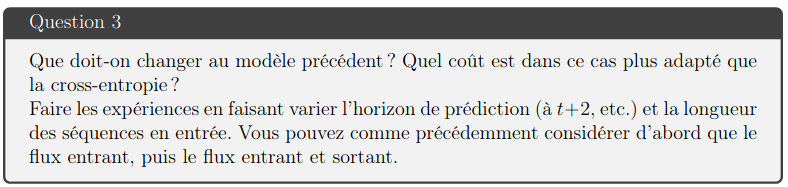

In [30]:
class RNN(nn.Module):
    
    def __init__(self,nb_dim,nb_latent,nb_output,nb_timestep,device) :
        super().__init__()
        
        self.nb_dim = nb_dim
        self.nb_latent = nb_latent
        self.nb_output = nb_output
        self.nb_timestep = nb_timestep
        
        self.weights_i = nn.Linear(nb_dim, nb_latent)
        
        self.weights_h = nn.Linear(nb_latent, nb_latent)
        
        self.weights_d = nn.Sequential(
            nn.Linear(nb_latent, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, nb_output)
        )
        
        
    def onestep(self,x,h) :
        """
        input :
        x : batch * dim
        h : batch * latent
        
        return :
            batch * latent
        """
        return torch.tanh((self.weights_i(x) +  self.weights_h(h) ))
    
    def forward(self,x,h) :
        """
        input : 
        x : length * batch * dim
        h : batch * latent 
        return :
            length * batch * latent
        """
        result = list()
        
        for t in range(x.shape[0]) :
            
            h = self.onestep(x[t],h)
            
        
        y = self.decode(h) # calcul de la derniere sortie
        
        for t in range(x.shape[0]) :
            
            h = self.onestep(y,h)
            
            y = self.decode(h)
            
            result.append(y.unsqueeze(0))
            
        result_t = torch.cat(result,dim=0)
        
        return result_t
        
    def decode(self,h) :
        """
        input : 
        h : batch * latent
        
        return :
            batch * output
        """
        return torch.softmax(torch.sigmoid(self.weights_d(h)),dim=1)

In [47]:
from torch.utils.data import  DataLoader
import torch


device = torch.device("cpu")

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

PATH = "./data/"

matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch", "rb"))
ds_train = ForecastMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = ForecastMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length=LENGTH, stations_max=ds_train.stations_max)
data_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)


nb_dim = DIM_INPUT
nb_output = DIM_INPUT
nb_timestep = LENGTH
batch = BATCH_SIZE
nb_latent = 10
nb_epoch = 500

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0004)

writer = SummaryWriter("./runs/tp4_question2")


n = 10

print(f"batch : {batch}")
print(f"nb_dim : {nb_dim}")
print(f"length : {nb_timestep}")
print(f"nb_latent : {nb_latent}")

list_error = list()
list_score_train = list()
list_score_test = list()

Xytrain = get_Xy(ds_train)
Xytest = get_Xy(ds_test)

for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,d in data_train :
        
        X_t = torch.as_tensor(X , dtype = torch.float32, device = device) 

        print(X_t.shape)
        
        if X_t.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X_t[:n,:,:],h)
        y = X_t[n:,:,:]
        
        mse = torch.nn.SmoothL1Loss()

        loss = ce(y_pred,y)
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

/tmp/ipykernel_16162/2421022990.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)
/tmp/ipykernel_16162/2421022990.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(y)


batch : 32
nb_dim : 2
length : 20
nb_latent : 10


  0%|                                                   | 0/500 [00:00<?, ?it/s]

torch.Size([32, 19, 10, 2])
torch.Size([32, 19, 10, 2])


ZeroDivisionError: division by zero

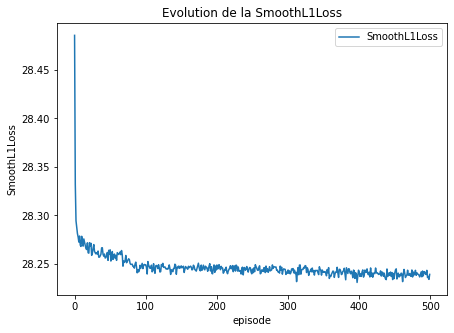

In [22]:
plt.figure(figsize=(7,5))
plt.title("Evolution de la SmoothL1Loss")
plt.xlabel("episode")
plt.ylabel("SmoothL1Loss")
plt.plot(list_error, label = "SmoothL1Loss")
plt.legend()
plt.show()

## Génération de séquence

In [40]:
import numpy as np
words = list()
text = ""

with open('./data/trump_full_speech.txt') as file:
    next_line = file.readline()
    while next_line:
        
        words += next_line.split()
        text += next_line
        
        next_line = file.readline()
print(len(words))
words = words[:10000]
print(len(words))
print(len(text))

235115
10000
1341228


In [16]:
print(words[:20])

['Trump:', 'Wow.', 'Whoa.', 'That', 'is', 'some', 'group', 'of', 'people.', 'Thousands.', 'So', 'nice,', 'thank', 'you', 'very', 'much.', "That's", 'really', 'nice.', 'Thank']


In [17]:
unique = list(set(words))
print(len(unique))

2436


In [18]:
words_index = list(map(unique.index, words))

In [19]:
print(words_index[:10])

[319, 256, 205, 1228, 2209, 657, 37, 926, 1495, 1894]


In [20]:
words_one_hot = np.array(list(map(lambda x: [int(i==x) for i in range(len(unique))], words_index)))

In [21]:
print(words_one_hot.shape)

(10000, 2436)


In [22]:
M = np.random.rand(2, words_one_hot.shape[0])

In [24]:
objects_vectors = M @ words_one_hot
print(objects_vectors.shape)

(2, 2436)


In [26]:
import string
import unicodedata
import torch
import sys
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset,DataLoader


## Liste des symboles autorisés
LETTRES = string.ascii_letters + string.punctuation+string.digits+' '
## Dictionnaire index -> lettre
id2lettre = dict(zip(range(1,len(LETTRES)+1),LETTRES))
id2lettre[0]='' ##NULL CHARACTER
## Dictionnaire lettre -> index
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))

def normalize(s):
    """ Nettoyage d'une chaîne de caractères. """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """ Transformation d'une chaîne de caractère en tenseur d'indexes """
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ Transformation d'une liste d'indexes en chaîne de caractères """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)

class TrumpDataset(Dataset):
    def __init__(self,text,maxsent=None,maxlen=None):
        """  Dataset pour les tweets de Trump
            * text : texte brut
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        full_text = normalize(text)
        self.phrases = [p[:maxlen].strip()+"." for p in full_text.split(".") if len(p)>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.MAX_LEN = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)
    def __getitem__(self,i):
        t = string2code(self.phrases[i])
        t = torch.cat([torch.zeros(self.MAX_LEN-t.size(0),dtype=torch.long),t])
        return t[:-1],t[1:]

In [43]:
ds = TrumpDataset(text, maxsent=50,maxlen=200)

In [44]:
for X,y in ds:
    print(X.shape)
    print(y.shape)
    break

torch.Size([181])
torch.Size([181])
